In [4]:
%load_ext autoreload
%autoreload 2

import os
import statistics

import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader

import config
import generate_stim_train_data
import lesion
import michaels_load
import mRNN
import observer
import stim
import stim_model
import utils

OBSERVER_TYPE = "gaussian"
LESION_PCT = 1.0
STIMULATION_TYPE = "gaussian"
ACTIVATION_TYPE = "ReTanh"
BATCH_SIZE = 64


observer_instance, stimulus, lesion_instance, activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                  stimulation_type=STIMULATION_TYPE,
                                  lesion_pct=LESION_PCT,
                                  activation_type=ACTIVATION_TYPE,
                                  batch_size=BATCH_SIZE)


DATA_DIR = "ben"
MRNN_DIR = "mrnn"
DATA_PATH = os.path.join(DATA_DIR, f"stim_data_brain_{run_type_str}.hdf5")
MODEL_PATH = os.path.join(DATA_DIR, f"ben_model_{ACTIVATION_TYPE}_{run_type_str}.pth")
MRNN_MODEL_PATH = os.path.join(MRNN_DIR, f"mrnn_{str(lesion_instance)}_{recovery_str}.pth")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# For reference: typical losses for a healthy network
# NOTE: if preds are all 0s, a loss of 0.02 is typical
# NOTE: if RNN activations are all 0s, 0.22 is typical
path = michaels_load.get_default_path()
rnn = mRNN.MichaelsRNN(init_data_path=path)
dataset = mRNN.MichaelsDataset(path)

losses = []
loader = DataLoader(
  dataset, batch_size=64, shuffle=True
)
for i_batch, sampled_batch in enumerate(loader):
    rnn.reset_hidden()

    din, dout = sampled_batch
    batch_size = din.shape[0]
    example_len = din.shape[1]

    preds = torch.empty((batch_size, example_len, rnn.output_dim))
    for tidx in range(example_len):
        cur_in = din[:, tidx, :]
        pred = rnn(cur_in.T)
        preds[:, tidx, :] = pred[:, :]

    loss = rnn.calc_loss(preds, dout)
    losses.append(loss.item())

print(losses)
print(statistics.mean(losses))

271 -----
[0.004438498988747597, 0.004444916732609272, 0.0044661290012300014, 0.004459753632545471, 0.004444377962499857, 0.004482027143239975, 0.004441259428858757, 0.004026447422802448]
0.004400426289066672


In [7]:
# NOTE: if we kill the entire network except for 12 neurons in M1, the
#       loss can still be as good as 0.005, which is only ~50% worse than
#       a healthy network!  So: lesions are not intensely powerful after
#       recovery.







# TODO: toss F5 observations (shrink model)
# TODO: as a result: shrink neuron count as well
# TODO: lower stimulation cardinatlity
# TODO: sum stims in advance? Make it more efficient...









mrnn = mRNN.generate(MRNN_MODEL_PATH, stimulus=stimulus, lesion=lesion_instance,
                     recover_after_lesion=recovery_mode)

Mean loss: 0.041662091854959726
Mean loss: 0.013194565428420901
Mean loss: 0.0075164211448282
Mean loss: 0.005665498203597963
Mean loss: 0.005107404140289873
Mean loss: 0.004913499637041241
Mean loss: 0.004836475709453225
Mean loss: 0.004781277384608984
Mean loss: 0.004728552128653973
Mean loss: 0.004715249175205827
Mean loss: 0.004701454658061266
Mean loss: 0.004700526071246713
Mean loss: 0.004691261216066778
Mean loss: 0.004696682910434902


In [8]:
# Reload, so we can pick up from here
mrnn = mRNN.load_from_file(MRNN_MODEL_PATH, lesion=lesion_instance, stimulus=stimulus)

In [14]:
# Generate the training data for our stimulation model (referred
# to as "brain emulator network", or "BEN")
x = generate_stim_train_data.generate(DATA_PATH, mrnn,
                                      observer_instance=observer_instance,
                                      stim_max_power=4.5)

1622427440.5168498 Generating example 0
1622427443.8399596 Generating example 1
1622427447.7408793 Generating example 2
1622427451.468749 Generating example 3
1622427454.973484 Generating example 4
1622427458.7117145 Generating example 5
1622427462.4199286 Generating example 6
1622427465.7018719 Generating example 7
1622427469.021236 Generating example 8
1622427472.8186095 Generating example 9
1622427476.352007 Generating example 10
1622427480.2228994 Generating example 11
1622427484.3472621 Generating example 12
1622427487.6676483 Generating example 13
1622427490.7985342 Generating example 14
1622427494.1035287 Generating example 15
1622427497.1108987 Generating example 16
1622427500.8751893 Generating example 17
1622427504.3027945 Generating example 18
1622427507.9154022 Generating example 19
1622427511.6265557 Generating example 20
1622427515.318545 Generating example 21
1622427519.2306402 Generating example 22
1622427521.80128 Generating example 23
1622427525.4417226 Generating exa

1622428127.9319801 Generating example 199
1622428131.273493 Generating example 200
1622428135.0925262 Generating example 201
1622428138.7846963 Generating example 202
1622428142.5457962 Generating example 203
1622428145.7035065 Generating example 204
1622428149.6280034 Generating example 205
1622428153.133908 Generating example 206
1622428156.0835474 Generating example 207
1622428158.8548932 Generating example 208
1622428162.538225 Generating example 209
1622428165.8004913 Generating example 210
1622428169.2771208 Generating example 211
1622428172.5581026 Generating example 212
1622428176.0894773 Generating example 213
1622428179.3564065 Generating example 214
1622428182.7111256 Generating example 215
1622428186.20073 Generating example 216
1622428189.5630739 Generating example 217
1622428193.0397067 Generating example 218
1622428195.9027781 Generating example 219
1622428198.982333 Generating example 220
1622428202.5210986 Generating example 221
1622428205.9936543 Generating example 22

1622428802.9794915 Generating example 396
1622428806.160578 Generating example 397
1622428809.766434 Generating example 398
1622428813.4434974 Generating example 399
1622428816.8143468 Generating example 400
1622428820.6678555 Generating example 401
1622428824.0752642 Generating example 402
1622428827.5687842 Generating example 403
1622428830.652356 Generating example 404
1622428833.5618658 Generating example 405
1622428837.3370702 Generating example 406
1622428841.1239743 Generating example 407
1622428844.6930735 Generating example 408
1622428847.8510253 Generating example 409
1622428852.0122917 Generating example 410
1622428855.7024527 Generating example 411
1622428859.0382843 Generating example 412
1622428862.0245755 Generating example 413
1622428864.751964 Generating example 414
1622428868.7683246 Generating example 415
1622428872.4924626 Generating example 416
1622428876.093416 Generating example 417
1622428880.0215588 Generating example 418
1622428883.4494302 Generating example 4

1622429479.6640198 Generating example 593
1622429482.9368083 Generating example 594
1622429486.221994 Generating example 595
1622429489.5778625 Generating example 596
1622429493.0978806 Generating example 597
1622429496.490614 Generating example 598
1622429499.3597264 Generating example 599
1622429502.455389 Generating example 600
1622429506.2765503 Generating example 601
1622429509.9496381 Generating example 602
1622429513.4483087 Generating example 603
1622429516.5376933 Generating example 604
1622429520.0244858 Generating example 605
1622429523.3800187 Generating example 606
1622429526.6693528 Generating example 607
1622429530.5100863 Generating example 608
1622429533.4963205 Generating example 609
1622429536.926936 Generating example 610
1622429540.7647212 Generating example 611
1622429544.1828067 Generating example 612
1622429547.5067294 Generating example 613
1622429550.3075728 Generating example 614
1622429554.1618187 Generating example 615
1622429557.473155 Generating example 6

1622430156.2954159 Generating example 790
1622430159.2413197 Generating example 791
1622430162.569964 Generating example 792
1622430165.9341803 Generating example 793
1622430169.3949559 Generating example 794
1622430172.6877418 Generating example 795
1622430175.650851 Generating example 796
1622430179.3338053 Generating example 797
1622430182.4735339 Generating example 798
1622430186.6773915 Generating example 799
1622430189.491244 Generating example 800
1622430193.0165377 Generating example 801
1622430196.319024 Generating example 802
1622430199.24338 Generating example 803
1622430203.0506551 Generating example 804
1622430206.3863857 Generating example 805
1622430209.3867047 Generating example 806
1622430212.8765376 Generating example 807
1622430216.8566587 Generating example 808
1622430221.2422383 Generating example 809
1622430224.1622984 Generating example 810
1622430227.99947 Generating example 811
1622430231.5836604 Generating example 812
1622430235.0658371 Generating example 813


1622430843.3192327 Generating example 987
1622430846.8661852 Generating example 988
1622430850.6823444 Generating example 989
1622430854.442397 Generating example 990
1622430858.0853152 Generating example 991
1622430861.1142495 Generating example 992
1622430864.030151 Generating example 993
1622430867.7296994 Generating example 994
1622430871.4903743 Generating example 995
1622430874.7692373 Generating example 996
1622430879.2905526 Generating example 997
1622430883.078279 Generating example 998
1622430886.9745913 Generating example 999
1622430890.8322601 Generating example 1000
1622430894.7542546 Generating example 1001
1622430898.2947574 Generating example 1002
1622430901.9560943 Generating example 1003
1622430905.7469308 Generating example 1004
1622430909.5867906 Generating example 1005
1622430912.544369 Generating example 1006
1622430915.887469 Generating example 1007
1622430919.4069617 Generating example 1008
1622430922.8027096 Generating example 1009
1622430926.192537 Generating 

1622431522.9781098 Generating example 1179
1622431527.0111406 Generating example 1180
1622431530.9903486 Generating example 1181
1622431534.499389 Generating example 1182
1622431537.828841 Generating example 1183
1622431541.255101 Generating example 1184
1622431544.7255414 Generating example 1185
1622431548.7655857 Generating example 1186
1622431552.1671383 Generating example 1187
1622431556.0935013 Generating example 1188
1622431559.3127136 Generating example 1189
1622431563.1156836 Generating example 1190
1622431566.7628846 Generating example 1191
1622431570.7255204 Generating example 1192
1622431573.8091779 Generating example 1193
1622431577.9026184 Generating example 1194
1622431581.2767642 Generating example 1195
1622431584.8172712 Generating example 1196
1622431588.1696587 Generating example 1197
1622431591.9663095 Generating example 1198
1622431595.0274282 Generating example 1199
1622431597.733411 Generating example 1200
1622431601.7338002 Generating example 1201
1622431605.8786

1622432196.4440327 Generating example 1371
1622432199.8388908 Generating example 1372
1622432203.0933976 Generating example 1373
1622432206.701047 Generating example 1374
1622432210.386862 Generating example 1375
1622432213.175293 Generating example 1376
1622432216.7566316 Generating example 1377
1622432220.9413335 Generating example 1378
1622432224.340912 Generating example 1379
1622432228.1254823 Generating example 1380
1622432231.4911454 Generating example 1381
1622432234.3129542 Generating example 1382
1622432237.056969 Generating example 1383
1622432240.2453518 Generating example 1384
1622432243.5820062 Generating example 1385
1622432246.8065073 Generating example 1386
1622432250.6870735 Generating example 1387
1622432254.426454 Generating example 1388
1622432257.898248 Generating example 1389
1622432261.7210586 Generating example 1390
1622432265.2304118 Generating example 1391
1622432268.8329704 Generating example 1392
1622432271.9345317 Generating example 1393
1622432274.5829926

1622432850.5098212 Generating example 1563
1622432854.184805 Generating example 1564
1622432857.4241908 Generating example 1565
1622432861.0489738 Generating example 1566
1622432864.8544445 Generating example 1567
1622432868.5256407 Generating example 1568
1622432871.0706208 Generating example 1569
1622432873.9375281 Generating example 1570
1622432877.2871678 Generating example 1571
1622432880.552088 Generating example 1572
1622432883.7512548 Generating example 1573
1622432886.8264918 Generating example 1574
1622432890.1786153 Generating example 1575
1622432893.8765147 Generating example 1576
1622432897.1300368 Generating example 1577
1622432900.5130196 Generating example 1578
1622432904.3880882 Generating example 1579
1622432907.2780287 Generating example 1580
1622432910.587183 Generating example 1581
1622432914.0442834 Generating example 1582
1622432917.521382 Generating example 1583
1622432921.2748172 Generating example 1584
1622432924.2149594 Generating example 1585
1622432927.5431

1622433511.2122302 Generating example 1755
1622433514.7955973 Generating example 1756
1622433517.9627566 Generating example 1757
1622433521.791493 Generating example 1758
1622433525.4961207 Generating example 1759
1622433528.676504 Generating example 1760
1622433532.0139623 Generating example 1761
1622433535.5110853 Generating example 1762
1622433539.6399138 Generating example 1763
1622433542.7707477 Generating example 1764
1622433546.4840949 Generating example 1765
1622433549.792504 Generating example 1766
1622433553.3629916 Generating example 1767
1622433556.2758508 Generating example 1768
1622433559.1270714 Generating example 1769
1622433562.3547378 Generating example 1770
1622433565.9037833 Generating example 1771
1622433569.007026 Generating example 1772
1622433572.3739552 Generating example 1773
1622433575.7383523 Generating example 1774
1622433579.3823543 Generating example 1775
1622433583.1388893 Generating example 1776
1622433587.0162177 Generating example 1777
1622433590.3035

1622434176.2184758 Generating example 1947
1622434179.9820523 Generating example 1948
1622434184.0812833 Generating example 1949
1622434188.1108599 Generating example 1950
1622434191.6920815 Generating example 1951
1622434195.6061158 Generating example 1952
1622434199.2192404 Generating example 1953
1622434203.093035 Generating example 1954
1622434206.6927543 Generating example 1955
1622434210.5268915 Generating example 1956
1622434214.5161135 Generating example 1957
1622434217.7720232 Generating example 1958
1622434221.4286485 Generating example 1959
1622434225.4119675 Generating example 1960
1622434229.0211143 Generating example 1961
1622434232.2729456 Generating example 1962
1622434236.1118252 Generating example 1963
1622434238.972832 Generating example 1964
1622434242.5576525 Generating example 1965
1622434246.1566548 Generating example 1966
1622434249.8132572 Generating example 1967
1622434253.4790287 Generating example 1968
1622434256.8311908 Generating example 1969
1622434260.33

In [15]:
dataset = stim_model.StimDataset(DATA_PATH)                                                                            
example_len = dataset[0][0].shape[0]                                                                        
in_dim = dataset[0][0].shape[1]                                                                             
out_dim = dataset[0][1].shape[1]

In [16]:
model = stim_model.StimModel(in_dim, out_dim, activation_func=activation)
#optimizer = Adam(model.parameters(), lr=0.006, weight_decay=4e-2)
optimizer = AdamW(model.parameters(), lr=0.005)

In [17]:
stim_model.train_model(dataset,
                       model,
                       optimizer,
                       example_len,
                       in_dim,
                       out_dim,
                       batch_size=BATCH_SIZE,
                       model_save_path=MODEL_PATH,
                       train_stop_thresh=0.0001)

Epoch: 0
Min loss: 0.09003888815641403
Min loss: 0.06356438994407654
Min loss: 0.04891417548060417
Min loss: 0.0410868376493454
Min loss: 0.035803619772195816
Min loss: 0.031218701973557472
Min loss: 0.027500644326210022
Min loss: 0.02437763661146164
Min loss: 0.02143293060362339
Min loss: 0.01950862444937229
Min loss: 0.01742842234671116
Min loss: 0.01677606627345085
Min loss: 0.015824560075998306
Min loss: 0.014993904158473015
Min loss: 0.014611647464334965
Min loss: 0.01422184333205223
Min loss: 0.013615836389362812
Min loss: 0.013256706297397614
Min loss: 0.012828423641622066
Min loss: 0.01235212292522192
Min loss: 0.012007053010165691
Min loss: 0.011774243786931038
Min loss: 0.01171747874468565
Min loss: 0.011511767283082008
Min loss: 0.011081533506512642
Min loss: 0.010721785947680473
Min loss: 0.010456942021846771
Min loss: 0.010066605173051357
Epoch: 1
Min loss: 0.009881380014121532
Min loss: 0.009782390668988228
Min loss: 0.009651257656514645
Min loss: 0.009586768224835396
Min

Epoch: 41
Min loss: 0.00031045509967952967
Epoch: 42
Min loss: 0.00029446938424371183
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Min loss: 0.00028638538788072765
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Min loss: 0.00028168197604827583
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Min loss: 0.00027977608260698617
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Min loss: 0.000277751125395298
Epoch: 68
Min loss: 0.000274751044344157
Epoch: 69
Epoch: 70
Epoch: 71
Min loss: 0.000273574551101774
Epoch: 72
Min loss: 0.00026636215625330806
Epoch: 73
Epoch: 74
Epoch: 75
Min loss: 0.00026252688257955015
Epoch: 76
Min loss: 0.0002568907511886209
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Min loss: 0.00025372454547323287
Epoch: 81
Epoch: 82
Min loss: 0.0002517340471968055
Min loss: 0.00024472165387123823
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Min loss: 0.00024253976880572736
Epoch: 89
Epoch: 90
Min loss: 0.0

torch.Size([341, 105])


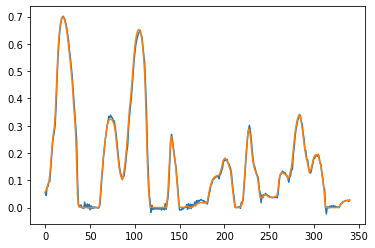

In [18]:
model.reset()

example_in, example_out = dataset[0]
example_len = example_in.shape[0]
out_dim = example_out.shape[1]
preds = torch.empty((example_len, out_dim))

for tidx in range(example_len):
    cur_in = example_in[tidx,:]
    cur_in = cur_in.reshape((1,) + cur_in.shape)
    pred = model(cur_in)
    preds[tidx, :] = pred[:]

plt.plot(preds[:,8].detach().numpy())
plt.plot(example_out[:,8])
print(preds.shape)
plt.show()